# Main task: Experiments

## 1) PCA

In [54]:
import matplotlib.pyplot as plt
from PIL import Image
import vlad_emb
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.decomposition import PCA
import util
from os.path import join

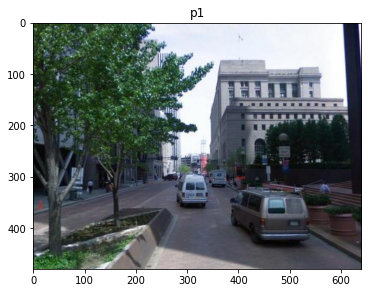

In [55]:
p1 = Image.open('./sample_pitt250k_3/q1.jpg')
plt.figure(figsize=(20, 20))
plt.subplot(1, 3, 1)
plt.title('p1')
plt.imshow(p1)

In [74]:
dir_lst = util.get_directories('sample_3rscan_10', True)
emb_lst = []
test = False
for dir in dir_lst:
    metaf_path = join('sample_3rscan_10',dir,'sequence','_info.txt')
    metaf = open(metaf_path,"r+")
    metaf.seek(0)
    metaf_lines = metaf.readlines()
    size = int(metaf_lines[-1].split()[-1])
    print('scene: {} size: {}'.format(dir, size))
    metaf.close()
    num_v = 30 # number of vertices in each graph
    step = size // num_v # uniform interval length 
    frames = ['0'*(6-len(str(x)))+str(x) for x in range(0, size, step)]
    for i, frame in enumerate(frames):
        # each vertex
        rgb_file = 'frame-' + frame + '.color.jpg'
        rgb_file_path = join('sample_3rscan_10', dir, 'sequence', rgb_file)
        # 1 get vlad encoding 
        img = Image.open(rgb_file_path)
        emb = torch.flatten(vlad_emb.get_vlad_emb(img))
        emb_lst.append(emb)
        if test: print('vlad_embbeding: {}'.format(emb.shape))

Directories in ' sample_3rscan_10 ' :
['0ad2d3a7-79e2-2212-9a1b-8737842a24e2', '0ad2d382-79e2-2212-98b3-641bf9d552c1', '0ad2d3a5-79e2-2212-9a9e-2502a05fa678', '0ad2d3a1-79e2-2212-9b99-a96495d9f7fe', '0ad2d3a3-79e2-2212-9a51-9094be707ec2', '0ad2d39d-79e2-2212-99aa-1e95c5b94289', '0ad2d38f-79e2-2212-98d2-9b5060e5e9b5', '0ad2d39b-79e2-2212-99ae-830c292cd079', '0ad2d384-79e2-2212-9b18-72b44eb5463f', '0a4b8ef6-a83a-21f2-8672-dce34dd0d7ca']
scene: 0ad2d3a7-79e2-2212-9a1b-8737842a24e2 size: 161
scene: 0ad2d382-79e2-2212-98b3-641bf9d552c1 size: 340
scene: 0ad2d3a5-79e2-2212-9a9e-2502a05fa678 size: 97
scene: 0ad2d3a1-79e2-2212-9b99-a96495d9f7fe size: 70
scene: 0ad2d3a3-79e2-2212-9a51-9094be707ec2 size: 99
scene: 0ad2d39d-79e2-2212-99aa-1e95c5b94289 size: 133
scene: 0ad2d38f-79e2-2212-98d2-9b5060e5e9b5 size: 365
scene: 0ad2d39b-79e2-2212-99ae-830c292cd079 size: 157
scene: 0ad2d384-79e2-2212-9b18-72b44eb5463f size: 139
scene: 0a4b8ef6-a83a-21f2-8672-dce34dd0d7ca size: 523


(328, 32768)


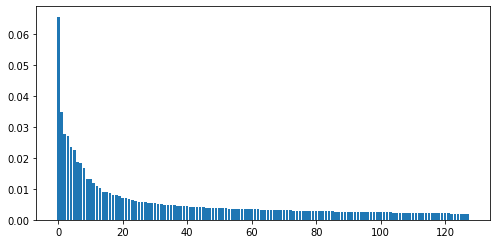

In [99]:
X = torch.stack(emb_lst).numpy()
print(X.shape)
pca = PCA(n_components=128)
pca.fit(X)
from matplotlib import pyplot as plt

# Set the figure size
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

# List of data points
data = pca.explained_variance_ratio_
x_axis = [x for x in range(len(data))]

# Plot bar chart with data points
plt.bar(x_axis, data)

# Display the plot
plt.show()

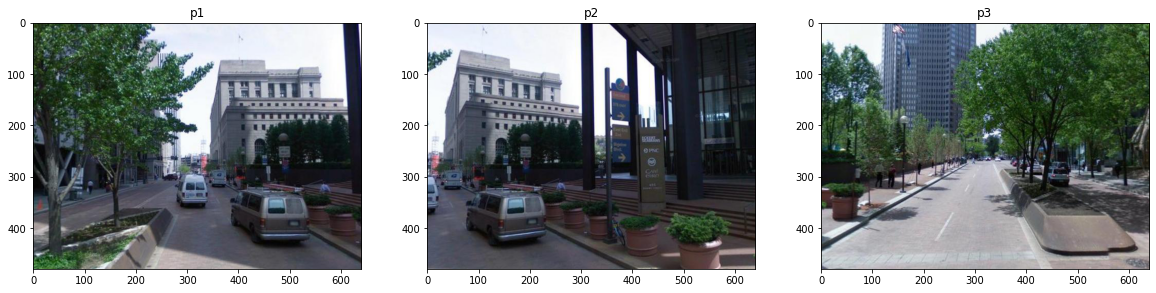

In [88]:
import matplotlib.pyplot as plt
from PIL import Image
p1 = Image.open('./sample_pitt250k_3/q1.jpg')
p2 = Image.open('./sample_pitt250k_3/q2.jpg')
p3 = Image.open('./sample_pitt250k_3/q3.jpg')
plt.figure(figsize=(20, 20))
plt.subplot(1, 3, 1)
plt.title('p1')
plt.imshow(p1)
plt.subplot(1, 3, 2)
plt.title('p2')
plt.imshow(p2)
plt.subplot(1, 3, 3)
plt.title('p3')
plt.imshow(p3)

In [89]:
p1_vlad = vlad_emb.get_vlad_emb(p1)
p2_vlad = vlad_emb.get_vlad_emb(p2)
p3_vlad = vlad_emb.get_vlad_emb(p3)

In [94]:
p1_vlad_32 = torch.from_numpy(pca.transform(p1_vlad))
p2_vlad_32 = torch.from_numpy(pca.transform(p2_vlad))
p3_vlad_32 = torch.from_numpy(pca.transform(p3_vlad))
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
output_similar = cos(p1_vlad_32, p2_vlad_32)
output_diff = cos(p1_vlad_32, p3_vlad_32)
print('Cosine Similarity for 128 emb:\nfor similar scenes: {}, \nfor different scenes: {}'.format(output_similar, output_diff))

print('')

output_similar = cos(p1_vlad, p2_vlad)
output_diff = cos(p1_vlad, p3_vlad)
print('Cosine Similarity for 32768 emb:\nfor similar scenes: {}, \nfor different scenes: {}'.format(output_similar, output_diff))

Cosine Similarity for 128 emb:
for similar scenes: tensor([0.7818], dtype=torch.float64), 
for different scenes: tensor([0.6241], dtype=torch.float64)

Cosine Similarity for 32768 emb:
for similar scenes: tensor([0.3917]), 
for different scenes: tensor([0.2119])


## 2) Visualize graph

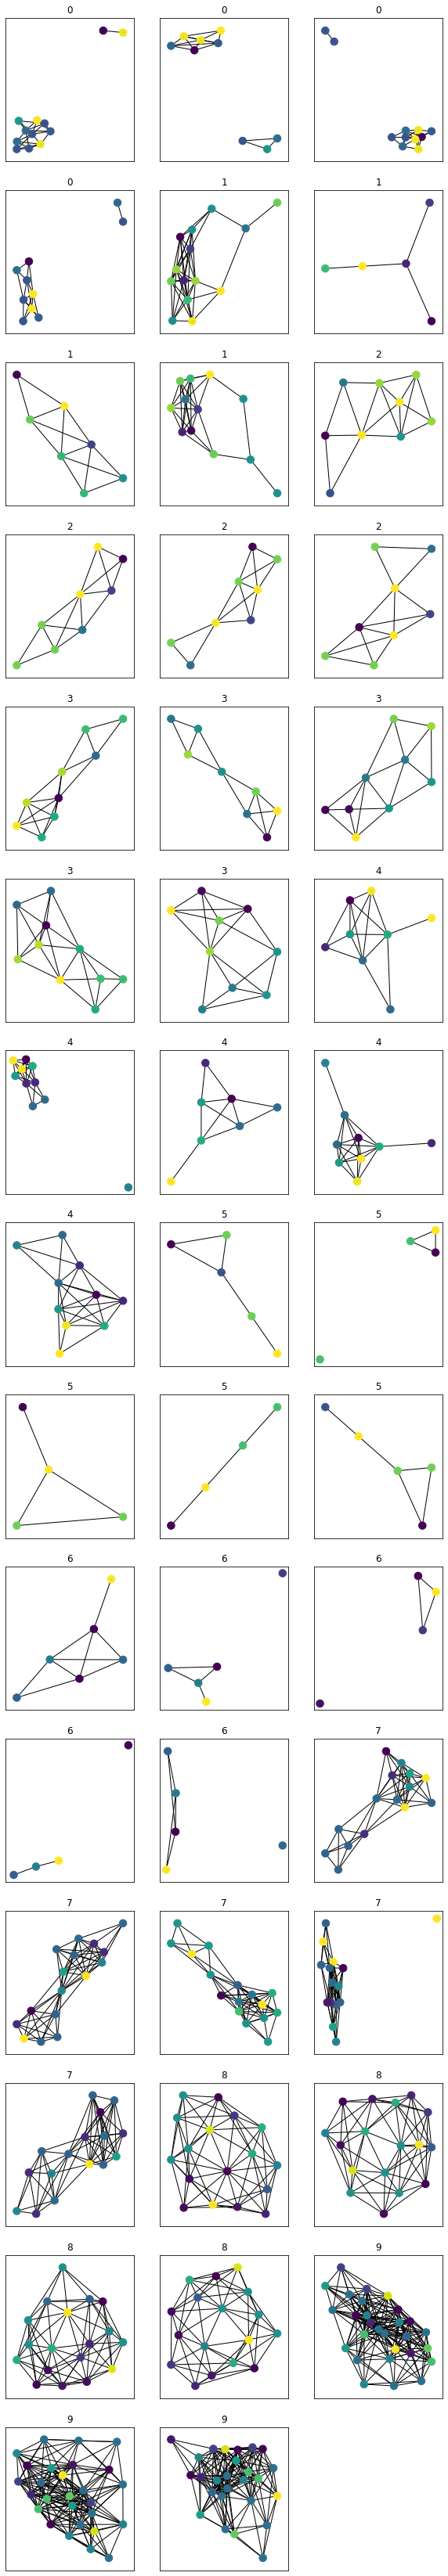

In [15]:
import networkx as nx
import matplotlib.pyplot as plt
f = open('pytorch_DGCNN-master/data/DEMO10/DEMO10.txt', 'r')
# f = open('pytorch_DGCNN-master/data/MUTAG/MUTAG.txt', 'r')
is_obj_graph = True
num_classes = 55
num_graphs = int(f.readline())
num_columns = 3
num_rows = (num_graphs // num_columns) + 1
# print(num_graphs)
plt.figure(figsize=(10, 60))
for i in range(num_graphs):
    # for one graph
    g_info = f.readline().split()
    num_vertices = int(g_info[0])
    label = g_info[1]
#     print(num_vertices)
    G = nx.Graph()
    if is_obj_graph:
        colors = []
    for j in range(num_vertices):
        # for one vertex
        vertex_info = f.readline().split()
        num_nbs = int(vertex_info[1])
        if is_obj_graph:
            obj_class = vertex_info[num_nbs+2:].index("1")
            colors.append(obj_class/num_classes)
        if num_nbs == 0:
            G.add_node(j)
        else:
            for k in range(2, num_nbs + 2):
                G.add_edge(j, int(vertex_info[k]))
    plt.subplot(num_rows, num_columns, i+1)
    plt.title(label)
    options = {
    "font_size": 1,
    "node_size": 90,
#     "node_color": "white",
#     "edgecolors": "black",
#     "linewidths": 5,
#     "width": 5,
    }
#     colors = [i/len(G.nodes) for i in range(len(G.nodes))]
    if is_obj_graph:
        nx.draw_networkx(G, **options, node_color=colors)
    else:
        nx.draw_networkx(G, **options)
f.close()

In [16]:
import util
util.generate_labels("sample_rooms_10.txt")

{'02b33dfb-be2b-2d54-92d2-cd012b2b3c40': 0,
 'fcf66d9e-622d-291c-84c2-bb23dfe31327': 0,
 '02b33df9-be2b-2d54-9062-1253be3ce186': 0,
 '02b33dfd-be2b-2d54-91d2-55454852009e': 0,
 '02b33e01-be2b-2d54-93fb-4145a709cec5': 1,
 'fcf66d8a-622d-291c-8429-0e1109c6bb26': 1,
 'fcf66d88-622d-291c-871f-699b2d063630': 1,
 '02b33e03-be2b-2d54-9129-5d28efdd68fa': 1,
 '095821f7-e2c2-2de1-9568-b9ce59920e29': 2,
 '2e369567-e133-204c-909a-c5da44bb58df': 2,
 '095821f9-e2c2-2de1-9707-8f735cd1c148': 2,
 '095821fb-e2c2-2de1-94df-20f2cb423bcb': 2,
 '0958220d-e2c2-2de1-9710-c37018da1883': 3,
 '0958220b-e2c2-2de1-96bc-739f09c1e8f8': 3,
 '09582205-e2c2-2de1-9475-1cdac7639e60': 3,
 '09582207-e2c2-2de1-972c-225d968c2ab4': 3,
 '09582209-e2c2-2de1-9610-08baed932919': 3,
 '09582212-e2c2-2de1-9700-fa44b14fbded': 4,
 '0958221b-e2c2-2de1-96b1-6233099811a0': 4,
 '09582214-e2c2-2de1-956a-64d8da4ba7cc': 4,
 '09582216-e2c2-2de1-97de-efcab1ef9c43': 4,
 '09582219-e2c2-2de1-9534-519142703037': 4,
 '09582225-e2c2-2de1-9564-f6681e

## 3) Object vertex focusing on 

In [2]:
# Get objects of interest 
objects = []
objects_of_interest = []
with open('objects_and_frequency.txt', 'r') as f:
    objects = f.readlines()
for object in objects:
    freq = int(object.split(",")[1])
    obj = object.split(",")[0]
    if freq > 100:
        objects_of_interest.append(obj)
num_objects_of_interest = len(objects_of_interest)

print(objects_of_interest, num_objects_of_interest)

['kitchen cabinet', 'box', 'sink', 'shelf', 'heater', 'kitchen counter', 'stove', 'blinds', 'commode', 'windowsill', 'lamp', 'radiator', 'clutter', 'towel', 'mirror', 'plant', 'toilet', 'door', 'table', 'chair', 'sofa', 'coffee table', 'stool', 'picture', 'trash can', 'item', 'bag', 'vase', 'pillow', 'monitor', 'pc', 'backpack', 'armchair', 'desk', 'light', 'counter', 'curtain', 'bed', 'rack', 'tv stand', 'tv', 'frame', 'blanket', 'bath cabinet', 'basket', 'clothes', 'bench', 'cushion', 'decoration', 'bucket', 'nightstand', 'couch', 'stand', 'wardrobe', 'shoes'] 55


In [7]:
# Construct one-hot vector
import torch
import numpy as np
a = np.array([x for x in range(num_objects_of_interest)])
one_hots = np.zeros((a.size, a.max()+1))
one_hots[np.arange(a.size),a] = 1
one_hots = torch.from_numpy(one_hots).int()
print(one_hots)

tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 0, 1]], dtype=torch.int32)


In [5]:
# Associate objects of interest with their one-hot class
obj_dic = {}
for i in range(num_objects_of_interest):
    obj_dic[objects_of_interest[i]] = one_hots[i]
print(obj_dic["pillow"])
"pillow" in obj_dic.keys()

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]


True

In [7]:
import util
util.get_object_info_json('3rscan/0a4b8ef6-a83a-21f2-8672-dce34dd0d7ca/semseg.v2.json', obj_dic)

[(tensor([ 0.3587,  0.3052, -1.1691]),
  -1,
  tensor([ 0.0000e+00, -2.2204e-16,  1.0000e+00])),
 (tensor([ 1.8113, -0.8993, -0.1680]),
  -1,
  tensor([-5.3626e-01, -8.4405e-01, -1.8742e-16])),
 (tensor([-1.0545,  2.3471, -0.6129]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]),
  tensor([ 9.5497e-01, -2.9670e-01, -6.5881e-17])),
 (tensor([-0.0219,  1.8741, -0.6107]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]),
  tensor([-5.8108e-01, -8.1385e-01, -1.8071e-16])),
 (tensor([ 0.0342,  1.1674, -0.9846]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

## 3.1) Build data.txt

In [1]:
import util
util.build_dataset(rooms_path='sample_rooms_10.txt', target_name='DEMO10', 
                pos_ind=0, feat_ind=1, base=0, method=0, ratio=1)
!head -10 ./pytorch_DGCNN-master/data/DEMO10/DEMO10.txt

44
12 0
0 5 1 4 6 7 10 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 4 0 6 7 10 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 1 9 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 5 4 5 6 10 11 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 8 0 3 5 6 7 8 10 11 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 5 3 4 6 8 11 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
0 7 0 1 3 4 5 8 11 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 4 0 1 4 10 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0

## 3.2) Build up cross validation

In [2]:
import util
util.build_cv_split_10fold('DEMO10', 44, 5)
!cat ./pytorch_DGCNN-master/data/DEMO10/10fold_idx/test_idx-1.txt

32
20
27
33
37


## 3.3) Run DGCNN

In [2]:
%cd pytorch_DGCNN-master
!pwd

/home/igor/Desktop/tao/tisl/tisl_localization_22s/pytorch_DGCNN-master
/home/igor/Desktop/tao/tisl/tisl_localization_22s/pytorch_DGCNN-master


In [4]:
!./run_DGCNN.sh DEMO10 3 5

3
CUDA_VISIBLE_DEVICES=0 python main.py       -seed 1       -data DEMO10       -fold 3       -learning_rate 0.00001       -num_epochs 50       -hidden 128       -latent_dim 32-32-32-1       -sortpooling_k 0.6       -out_dim 0       -batch_size 1       -gm DGCNN       -mode gpu       -dropout True       -test_number 5
====== begin of gnn configuration ======
| msg_average = 0
======   end of gnn configuration ======
Namespace(batch_size=1, conv1d_activation='ReLU', data='DEMO10', dropout=True, edge_feat_dim=0, extract_features=False, feat_dim=0, fold=3, gm='DGCNN', hidden=128, latent_dim=[32, 32, 32, 1], learning_rate=1e-05, max_lv=4, mode='gpu', num_class=0, num_epochs=50, out_dim=0, printAUC=False, seed=1, sortpooling_k=0.6, test_number=5)
loading data
# classes: 10
# maximum node tag: 1
# train: 39, # test: 5
k used in SortPooling is: 10
Initializing DGCNN
loss: 2.34251 acc: 0.00000: 100%|████████████| 39/39 [00:00<00:00, 50.13batch/s]
average training of epoch 0: loss 2.29254 acc 0.

loss: 2.25676 acc: 0.00000: 100%|███████████| 39/39 [00:00<00:00, 225.07batch/s]
average training of epoch 24: loss 2.28444 acc 0.07692 auc 0.00000
loss: 2.50672 acc: 0.00000: 100%|█████████████| 5/5 [00:00<00:00, 451.68batch/s]
average test of epoch 24: loss 2.45577 acc 0.00000 auc 0.00000
loss: 2.18060 acc: 1.00000: 100%|███████████| 39/39 [00:00<00:00, 169.42batch/s]
average training of epoch 25: loss 2.27177 acc 0.20513 auc 0.00000
loss: 2.51131 acc: 0.00000: 100%|█████████████| 5/5 [00:00<00:00, 466.86batch/s]
average test of epoch 25: loss 2.45882 acc 0.00000 auc 0.00000
loss: 2.33933 acc: 0.00000: 100%|███████████| 39/39 [00:00<00:00, 215.08batch/s]
average training of epoch 26: loss 2.27245 acc 0.12821 auc 0.00000
loss: 2.51568 acc: 0.00000: 100%|█████████████| 5/5 [00:00<00:00, 505.39batch/s]
average test of epoch 26: loss 2.46163 acc 0.00000 auc 0.00000
loss: 2.26460 acc: 0.00000: 100%|███████████| 39/39 [00:00<00:00, 208.57batch/s]
average training of epoch 27: loss 2.26861 

In [30]:
# Without feature
!CUDA_VISIBLE_DEVICES=0 python main.py       \
-seed 1       \
-data DEMO10       \
-fold 3       \
-learning_rate 0.001       \
-num_epochs 100       \
-hidden 128       \
-latent_dim 64-32-32-16-8       \
-sortpooling_k 1       \
-out_dim 8       \
-batch_size 1       \
-gm DGCNN       \
-mode gpu       \
-dropout False       \
-test_number 5 \
-extract_features True \
-max_lv 5

====== begin of gnn configuration ======
| msg_average = 0
======   end of gnn configuration ======
Namespace(batch_size=1, conv1d_activation='ReLU', data='DEMO10', dropout=True, edge_feat_dim=0, extract_features=True, feat_dim=0, fold=3, gm='DGCNN', hidden=128, latent_dim=[64, 32, 32, 16, 8], learning_rate=0.001, max_lv=5, mode='gpu', num_class=0, num_epochs=100, out_dim=8, printAUC=False, seed=1, sortpooling_k=1.0, test_number=5)
loading data
# classes: 10
# maximum node tag: 1
# train: 39, # test: 5
k used in SortPooling is: 28
Initializing DGCNN
loss: 2.29263 acc: 0.00000: 100%|████████████| 39/39 [00:00<00:00, 47.49batch/s]
average training of epoch 0: loss 2.30989 acc 0.00000 auc 0.00000
loss: 2.37061 acc: 0.00000: 100%|█████████████| 5/5 [00:00<00:00, 404.39batch/s]
average test of epoch 0: loss 2.34140 acc 0.00000 auc 0.00000
loss: 2.26770 acc: 0.00000: 100%|███████████| 39/39 [00:00<00:00, 147.08batch/s]
average training of epoch 1: loss 2.28390 acc 0.05128 auc 0.00000
loss: 2

loss: 0.40046 acc: 1.00000: 100%|███████████| 39/39 [00:00<00:00, 148.71batch/s]
average training of epoch 25: loss 1.09591 acc 0.53846 auc 0.00000
loss: 16.44345 acc: 0.00000: 100%|████████████| 5/5 [00:00<00:00, 386.35batch/s]
average test of epoch 25: loss 9.76825 acc 0.40000 auc 0.00000
loss: 1.45480 acc: 0.00000: 100%|███████████| 39/39 [00:00<00:00, 169.44batch/s]
average training of epoch 26: loss 1.23017 acc 0.38462 auc 0.00000
loss: 16.56955 acc: 0.00000: 100%|████████████| 5/5 [00:00<00:00, 415.81batch/s]
average test of epoch 26: loss 9.86397 acc 0.40000 auc 0.00000
loss: 1.66879 acc: 0.00000: 100%|███████████| 39/39 [00:00<00:00, 183.26batch/s]
average training of epoch 27: loss 1.06665 acc 0.48718 auc 0.00000
loss: 21.58100 acc: 0.00000: 100%|████████████| 5/5 [00:00<00:00, 469.76batch/s]
average test of epoch 27: loss 12.70879 acc 0.40000 auc 0.00000
loss: 1.79643 acc: 0.00000: 100%|███████████| 39/39 [00:00<00:00, 191.10batch/s]
average training of epoch 28: loss 1.08253

loss: 0.08782 acc: 1.00000: 100%|███████████| 39/39 [00:00<00:00, 187.57batch/s]
average training of epoch 52: loss 0.99964 acc 0.56410 auc 0.00000
loss: 23.19283 acc: 0.00000: 100%|████████████| 5/5 [00:00<00:00, 408.12batch/s]
average test of epoch 52: loss 13.87404 acc 0.40000 auc 0.00000
loss: 0.74948 acc: 1.00000: 100%|███████████| 39/39 [00:00<00:00, 171.29batch/s]
average training of epoch 53: loss 0.89621 acc 0.53846 auc 0.00000
loss: 24.98113 acc: 0.00000: 100%|████████████| 5/5 [00:00<00:00, 358.85batch/s]
average test of epoch 53: loss 14.89787 acc 0.40000 auc 0.00000
loss: 1.51982 acc: 1.00000: 100%|███████████| 39/39 [00:00<00:00, 171.79batch/s]
average training of epoch 54: loss 0.89748 acc 0.56410 auc 0.00000
loss: 26.95341 acc: 0.00000: 100%|████████████| 5/5 [00:00<00:00, 359.88batch/s]
average test of epoch 54: loss 15.99400 acc 0.40000 auc 0.00000
loss: 1.01978 acc: 1.00000: 100%|███████████| 39/39 [00:00<00:00, 172.15batch/s]
average training of epoch 55: loss 0.894

loss: 0.00274 acc: 1.00000: 100%|███████████| 39/39 [00:00<00:00, 164.47batch/s]
average training of epoch 79: loss 0.75466 acc 0.66667 auc 0.00000
loss: 28.14978 acc: 0.00000: 100%|████████████| 5/5 [00:00<00:00, 404.68batch/s]
average test of epoch 79: loss 16.58147 acc 0.40000 auc 0.00000
loss: 0.00623 acc: 1.00000: 100%|███████████| 39/39 [00:00<00:00, 169.03batch/s]
average training of epoch 80: loss 0.74868 acc 0.79487 auc 0.00000
loss: 24.26001 acc: 0.00000: 100%|████████████| 5/5 [00:00<00:00, 407.02batch/s]
average test of epoch 80: loss 14.28732 acc 0.40000 auc 0.00000
loss: 0.75970 acc: 1.00000: 100%|███████████| 39/39 [00:00<00:00, 169.23batch/s]
average training of epoch 81: loss 0.70257 acc 0.76923 auc 0.00000
loss: 23.91655 acc: 0.00000: 100%|████████████| 5/5 [00:00<00:00, 406.46batch/s]
average test of epoch 81: loss 14.24790 acc 0.40000 auc 0.00000
loss: 1.29643 acc: 1.00000: 100%|███████████| 39/39 [00:00<00:00, 142.75batch/s]
average training of epoch 82: loss 0.709

In [3]:
# With feature
!CUDA_VISIBLE_DEVICES=0 python main.py       \
-seed 1       \
-data DEMO10       \
-fold 3       \
-learning_rate 0.001       \
-num_epochs 100       \
-hidden 128       \
-latent_dim 64-32-32-16-8       \
-sortpooling_k 1       \
-out_dim 8       \
-batch_size 64       \
-gm DGCNN       \
-mode gpu       \
-dropout False       \
-test_number 5 \
-extract_features True \
-max_lv 5

====== begin of gnn configuration ======
| msg_average = 0
======   end of gnn configuration ======
Namespace(batch_size=1, conv1d_activation='ReLU', data='DEMO10', dropout=True, edge_feat_dim=0, extract_features=True, feat_dim=0, fold=3, gm='DGCNN', hidden=128, latent_dim=[64, 32, 32, 16, 8], learning_rate=0.001, max_lv=5, mode='gpu', num_class=0, num_epochs=100, out_dim=8, printAUC=False, seed=1, sortpooling_k=1.0, test_number=5)
loading data
# classes: 10
# maximum node tag: 1
# train: 39, # test: 5
k used in SortPooling is: 28
Initializing DGCNN
loss: 2.24874 acc: 0.00000: 100%|████████████| 39/39 [00:00<00:00, 45.10batch/s]
average training of epoch 0: loss 2.31296 acc 0.07692 auc 0.00000
loss: 2.45924 acc: 0.00000: 100%|█████████████| 5/5 [00:00<00:00, 391.84batch/s]
average test of epoch 0: loss 2.38869 acc 0.00000 auc 0.00000
loss: 2.26138 acc: 0.00000: 100%|███████████| 39/39 [00:00<00:00, 169.79batch/s]
average training of epoch 1: loss 2.25143 acc 0.20513 auc 0.00000
loss: 2

loss: 0.68953 acc: 1.00000: 100%|███████████| 39/39 [00:00<00:00, 174.64batch/s]
average training of epoch 25: loss 0.53131 acc 0.74359 auc 0.00000
loss: 8.23267 acc: 0.00000: 100%|█████████████| 5/5 [00:00<00:00, 409.51batch/s]
average test of epoch 25: loss 4.45728 acc 0.40000 auc 0.00000
loss: 0.00016 acc: 1.00000: 100%|███████████| 39/39 [00:00<00:00, 170.56batch/s]
average training of epoch 26: loss 0.54054 acc 0.76923 auc 0.00000
loss: 8.33706 acc: 0.00000: 100%|█████████████| 5/5 [00:00<00:00, 399.97batch/s]
average test of epoch 26: loss 4.42785 acc 0.40000 auc 0.00000
loss: 0.44499 acc: 1.00000: 100%|███████████| 39/39 [00:00<00:00, 175.12batch/s]
average training of epoch 27: loss 0.43122 acc 0.84615 auc 0.00000
loss: 9.28833 acc: 0.00000: 100%|█████████████| 5/5 [00:00<00:00, 379.35batch/s]
average test of epoch 27: loss 4.86800 acc 0.40000 auc 0.00000
loss: 0.00002 acc: 1.00000: 100%|███████████| 39/39 [00:00<00:00, 184.18batch/s]
average training of epoch 28: loss 0.40832 

loss: 0.00000 acc: 1.00000: 100%|███████████| 39/39 [00:00<00:00, 173.02batch/s]
average training of epoch 52: loss 0.01947 acc 1.00000 auc 0.00000
loss: 27.65029 acc: 0.00000: 100%|████████████| 5/5 [00:00<00:00, 431.93batch/s]
average test of epoch 52: loss 15.99133 acc 0.40000 auc 0.00000
loss: 0.00348 acc: 1.00000: 100%|███████████| 39/39 [00:00<00:00, 188.70batch/s]
average training of epoch 53: loss 0.04864 acc 0.97436 auc 0.00000
loss: 29.28666 acc: 0.00000: 100%|████████████| 5/5 [00:00<00:00, 443.20batch/s]
average test of epoch 53: loss 16.89052 acc 0.40000 auc 0.00000
loss: 0.00001 acc: 1.00000: 100%|███████████| 39/39 [00:00<00:00, 181.50batch/s]
average training of epoch 54: loss 0.00794 acc 1.00000 auc 0.00000
loss: 29.90348 acc: 0.00000: 100%|█████████████| 5/5 [00:00<00:00, 90.68batch/s]
average test of epoch 54: loss 17.17120 acc 0.40000 auc 0.00000
loss: 0.01028 acc: 1.00000: 100%|███████████| 39/39 [00:00<00:00, 170.26batch/s]
average training of epoch 55: loss 0.002

loss: 0.00006 acc: 1.00000: 100%|███████████| 39/39 [00:00<00:00, 143.38batch/s]
average training of epoch 79: loss 0.01019 acc 1.00000 auc 0.00000
loss: 27.33642 acc: 0.00000: 100%|████████████| 5/5 [00:00<00:00, 394.05batch/s]
average test of epoch 79: loss 15.94647 acc 0.40000 auc 0.00000
loss: 0.00000 acc: 1.00000: 100%|███████████| 39/39 [00:00<00:00, 174.59batch/s]
average training of epoch 80: loss 0.00933 acc 1.00000 auc 0.00000
loss: 27.72088 acc: 0.00000: 100%|████████████| 5/5 [00:00<00:00, 405.94batch/s]
average test of epoch 80: loss 16.11978 acc 0.40000 auc 0.00000
loss: 0.00005 acc: 1.00000: 100%|███████████| 39/39 [00:00<00:00, 171.26batch/s]
average training of epoch 81: loss 0.01581 acc 1.00000 auc 0.00000
loss: 27.24294 acc: 0.00000: 100%|████████████| 5/5 [00:00<00:00, 351.55batch/s]
average test of epoch 81: loss 15.83851 acc 0.40000 auc 0.00000
loss: 0.01451 acc: 1.00000: 100%|███████████| 39/39 [00:00<00:00, 167.83batch/s]
average training of epoch 82: loss 0.002